# HAC Pilot Report

## Analytics Strategy - FAERS PoC

This notebook will walk the reader through the steps of the analytics and ingestion strategy for the Health Analytics Collective (HAC) pilot.  This pilot uses publicly available FAERS data to produce interactive descriptive visualizations, providing the end-user insight into adverse event cases.  A Microsoft Azure File Storage Container is used to store data, with the Julia Programming Language used to run analytics.

**Data Scientists:**  Richard Bryant, Chris Hurley

#### Procedure
* Data are downloaded from the FAERS website: https://fis.fda.gov/extensions/FPD-QDE-FAERS/FPD-QDE-FAERS.html
* Data are uploaded manually to the Microsoft Azure File Storage Containter "faerspoc".
* Make sure to "connect" to the storage container (only happens once)
* Map to the storage container as a file share in Windows (Z:\). 
* Using the DataFrames package in Julia, the 2017 Q2 data are imported using the readtable() function. 
* Next, the data must be transformed into a "tidy" format for analytics to be run.  This transformation (joining, filtering, subsetting, grouped summaries) is performed using Julia.
* Functions are written for the analytics.  This enables the functions to be proactively applied to other analytics endeavors.
    * These functions are based on the 2018 FAERS proof of concept.
* Lastly, the visualization functions are run.  Output is embedded into a Jupyter Notebook.
    * Visualizations beyond the capabilities of Julia are produced in PowerBI.
* The end user will "ingest" the analytics via a combination of a Jupyter Notebook with documentation, code, and comments included.  More complex analytics will be provided via PowerBI.

## Entity Relationship Diagram

<img src="ERD.png">

## Code: ETL

In [59]:
# Must add CSV, ReadStat, DataFrames and Gadfly packages needed for this project
# import Pkg; Pkg.add("Pkg")
Pkg.add("CSV")
Pkg.add("ReadStat")
Pkg.add("DataFrames")
Pkg.add("Gadfly")
Pkg.add("Compose")
Pkg.add("StatFiles")
Pkg.add("VegaLite") 
Pkg.add("VegaDatasets")
import Pkg; Pkg.add("Pkg")
import Pkg; Pkg.add("JSON")
import Pkg; Pkg.add("Requests") 
Pkg.clone("https://github.com/plotly/Plotly.jl")
import Pkg; Pkg.add("Plotly")



# Don't add NodeJS but know that it is needed.
#Pkg.add("NodeJS")
#Pkg.build("NodeJS")
# Pkg.add("VegaLite") 
# Pkg.add("VegaDatasets")
# Pkg.add("DataVoyager")
# Pkg.add("IJulia")
# Pkg.build("VegaLite")


 Resolving package versions...
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
 [no changes]
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
 [no changes]
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
 [no changes]
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
 [no changes]
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `C:\Users\musgr\.julia

Pkg.Types.ResolverError: Unsatisfiable requirements detected for package Requests [df88083b]:
 Requests [df88083b] log:
 ├─possible versions are: [0.0.1-0.0.8, 0.1.0-0.1.1, 0.2.0-0.2.4, 0.3.0-0.3.13, 0.4.0-0.4.1, 0.5.0-0.5.1] or uninstalled
 ├─restricted to versions * by an explicit requirement, leaving only versions [0.0.1-0.0.8, 0.1.0-0.1.1, 0.2.0-0.2.4, 0.3.0-0.3.13, 0.4.0-0.4.1, 0.5.0-0.5.1]
 ├─restricted by compatibility requirements with JSON [682c06a0] to versions: [0.3.8-0.3.13, 0.4.0-0.4.1, 0.5.0-0.5.1] or uninstalled, leaving only versions: [0.3.8-0.3.13, 0.4.0-0.4.1, 0.5.0-0.5.1]
 │ └─JSON [682c06a0] log:
 │   ├─possible versions are: [0.1.0-0.1.1, 0.2.0-0.2.4, 0.3.0-0.3.9, 0.4.0-0.4.6, 0.5.0-0.5.4, 0.6.0-0.6.1, 0.7.0-0.7.1, 0.8.0-0.8.3, 0.9.0-0.9.1, 0.10.0, 0.11.0, 0.12.0, 0.13.0, 0.14.0, 0.15.0-0.15.2, 0.16.0-0.16.4, 0.17.1-0.17.2, 0.18.0, 0.19.0, 0.20.0, 0.21.0] or uninstalled
 │   └─restricted to versions 0.20.0 by an explicit requirement, leaving only versions 0.20.0
 └─restricted by julia compatibility requirements to versions: uninstalled — no versions left

In [2]:
# Load required libraries
# using DataFrames, CSV, Gadfly, Compose, ReadStat, StatFiles, VegaLite, VegaDatasets;
using DataFrames, CSV, Gadfly, StatFiles, ReadStat

In [11]:
# Read tables using the updated CSV.jl package v0.5.3
   demo17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\DEMO17Q2.txt"; header = 1, delim = '$')
   drug17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\DRUG17Q2.txt"; header = 1, delim = '$')
   indi17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\INDI17Q2.txt"; header = 1, delim = '$')
   outc17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\OUTC17Q2.txt"; header = 1, delim = '$')
   reac17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\REAC17Q2.txt"; header = 1, delim = '$')
   rpsr17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\RPSR17Q2.txt"; header = 1, delim = '$')
   ther17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\THER17Q2.txt"; header = 1, delim = '$')
   ther17q2 = CSV.read("C:\\Users\\musgr\\.juliapro\\MMS\\THER17Q2.txt"; header = 1, delim = '$', datarow=195880)

,primaryid,caseid,dsg_drug_seq,start_dt,end_dt,dur,dur_cod
,Int64,Int64,Int64,Int64⍰,Int64⍰,Float64⍰,String⍰
1,134224692,13422469,35,20170328,20170328,missing,missing
2,134224701,13422470,1,20170404,20170404,missing,missing
3,134224701,13422470,2,20170325,20170403,missing,missing
4,134224711,13422471,1,2006,missing,missing,missing
5,134224731,13422473,1,20150127,missing,missing,missing
6,134224761,13422476,1,missing,missing,2.5,YR
7,134224771,13422477,1,20170322,20170322,missing,missing
8,134224902,13422490,1,20170119,201703,missing,missing
9,134224911,13422491,1,20170408,20170410,missing,missing


In [12]:
# Read SAS data using a function from the StatFiles package
using StatFiles, DataFrames
meddra20 = load("C:\\Users\\musgr\\.juliapro\\MMS\\meddra20_0.sas7bdat") |> DataFrame
m20=read_sas7bdat("C:\\Users\\musgr\\.juliapro\\MMS\\meddra20_0.sas7bdat")
meddra20=DataFrame(m20.data,m20.headers)

,llt_code,llt_name,pt_code,llt_whoart_code
,DataValu…,DataValu…,DataValu…,DataValu…
1,1.0e7,"""\""Ventilation\"" pneumonitis""",1.00019e7,""""""
2,1.0e7,"""\""Ventilation\"" pneumonitis""",1.00019e7,""""""
3,1.0e7,"""11-beta-hydroxylase deficiency""",1.0e7,""""""
4,1.0e7,"""11-beta-hydroxylase deficiency""",1.0e7,""""""
5,1.0e7,"""11-oxysteroid activity incr""",1.00333e7,""""""
6,1.0e7,"""11-oxysteroid activity increased""",1.00333e7,""""""
7,1.0e7,"""17 ketosteroids urine""",1.0e7,""""""
8,1.00616e7,"""17 ketosteroids urine abnormal""",1.00616e7,""""""
9,1.0e7,"""17 ketosteroids urine abnormal NOS""",1.00616e7,""""""


In [13]:
# There are some columns that need to be renamed.
# We can envision a future state where this is automated... for now manual.
indi17q2 = rename(indi17q2, :indi_drug_seq => :drug_seq)
ther17q2 = rename(ther17q2, :dsg_drug_seq => :drug_seq);

In [14]:
# For proof-of-concept speed purposes, we will use only the first 10,000 rows of each dataset.
demo17q2 = first(demo17q2, 10000)
drug17q2 = first(drug17q2, 10000)
indi17q2 = first(indi17q2, 10000)
outc17q2 = first(outc17q2, 10000)
reac17q2 = first(reac17q2, 10000)
rpsr17q2 = first(rpsr17q2, 10000)
ther17q2 = first(ther17q2, 10000);

In [15]:
########## Perform joins
# Pull in indications for use into drug file table
drug_ind = join(
    drug17q2[:, [:primaryid, :caseid, :drug_seq, :drugname, :route, :cum_dose_chr, :dose_amt,
        :dose_unit, :dose_form, :dose_freq, :role_cod]],
    indi17q2[:, [:primaryid, :drug_seq, :indi_pt]],
    on = [:primaryid, :drug_seq], kind = :left
)

drug_ind_ther = join(
    drug_ind, ther17q2[:, [:primaryid, :drug_seq, :start_dt, :end_dt, :dur, :dur_cod]],
    on = [:primaryid, :drug_seq], kind = :left
)

# Pull reaction data into patient demographic table
demo_reac = join(
    demo17q2[:, [:primaryid, :caseid, :event_dt, :age, :age_cod, :age_grp, :sex, :wt, :occr_country]],
    reac17q2[:, [:primaryid, :pt, :drug_rec_act]],
    on = :primaryid, kind = :left,
)

# Pull outcomes information into the previous table
demo_reac_out = join(
    demo_reac, outc17q2[:, [:primaryid, :outc_cod]], on = :primaryid, kind = :left
)

# Concatenate previous table with report source information
demo_reac_out_source = join(
    demo_reac_out, rpsr17q2[:, [:primaryid, :rpsr_cod]], on = :primaryid, kind = :left
)

# Lastly, join the (Drug/Therapy/Indication) and (Demographic/Reaction/Outcome/Report Source)
# combined sets into one set with all this information in one place.
#faers17 = join(drug_ind_ther, delete!(demo_reac_out_source, :caseid), on = :primaryid, kind = :left);
faers17 = join(drug_ind_ther, deletecols!(demo_reac_out_source, :caseid), on = :primaryid, kind = :left);
########## End joins

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[15]:31
└ @ Core In[15]:31


In [16]:
########## Perform transformations
# Begin by storing a vector of counts by PT, where PT is "Preferred Term", or the event.
faers17q2_1 = by(faers17, :pt, d -> DataFrame(count_pt_17q2 = nrow(d)))

# Append this vector to the combined FAERS dataset.
faers17q2_2 = join(faers17, faers17q2_1, on = :pt, kind = :left, makeunique = true)

# Create a vector of counts by combination of Drug, and PT.
faers17q2_3 = by(faers17q2_2, [:drugname, :pt],
    d -> DataFrame(count_dpt_17q2 = nrow(d)))

#
faers17q2_4 = join(faers17q2_2, faers17q2_3, on = [:drugname, :pt], kind = :left,
    makeunique = true)

faers17q2_4[:count_percentage_17q2] =
    (faers17q2_4[:count_dpt_17q2] ./ faers17q2_4[:count_pt_17q2]) .* 100;
########## End transformations

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:15
└ @ Core In[16]:15
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[16]:15
└ @ Core In[16]:15
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[16]:15
└ @ Core In[16]:15


In [17]:
#Show dataframe faers17q2_1

withenv("LINES" => 5) do
    display(faers17q2_1)
end

,pt,count_pt_17q2
,String⍰,Int64
1,Blood count abnormal,29
2,Fatigue,2479
3,Tooth discolouration,5
4,Amaurosis fugax,20
5,Atrial fibrillation,314
⋮,⋮,⋮


In [18]:
#Show dataframe faers17q2_1

withenv("LINES" => 5) do
    display(faers17q2_2)
end

,primaryid,caseid,drug_seq,drugname,route,cum_dose_chr,dose_amt,dose_unit
,Int64,Int64,Int64,String,String⍰,Float64⍰,Float64⍰,String⍰
1,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
2,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
3,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
4,100052112,10005211,2,JAKAFI,Oral,missing,5.0,MG
5,100052112,10005211,2,JAKAFI,Oral,missing,5.0,MG
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [19]:
#Show dataframe faers17q2_1

withenv("LINES" => 5) do
    display(faers17q2_3)
end

,drugname,pt,count_dpt_17q2
,String,String⍰,Int64
1,JAKAFI,Blood count abnormal,3
2,JAKAFI,Fatigue,7
3,JAKAFI,Tooth discolouration,3
4,PROPANOLOL /00030001/,Blood count abnormal,2
5,PROPANOLOL /00030001/,Fatigue,2
⋮,⋮,⋮,⋮


In [20]:
#Show dataframe faers17q2_1

withenv("LINES" => 5) do
    display(faers17q2_4)
end

,primaryid,caseid,drug_seq,drugname,route,cum_dose_chr,dose_amt,dose_unit
,Int64,Int64,Int64,String,String⍰,Float64⍰,Float64⍰,String⍰
1,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
2,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
3,100052112,10005211,1,JAKAFI,Oral,missing,missing,missing
4,100052112,10005211,2,JAKAFI,Oral,missing,5.0,MG
5,100052112,10005211,2,JAKAFI,Oral,missing,5.0,MG
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


In [21]:
# View final dataset.  ETL is complete.
first(faers17q2_4, 10)

,primaryid,caseid,drug_seq,drugname,route
,Int64,Int64,Int64,String,String⍰
1,100052112,10005211,1,JAKAFI,Oral
2,100052112,10005211,1,JAKAFI,Oral
3,100052112,10005211,1,JAKAFI,Oral
4,100052112,10005211,2,JAKAFI,Oral
5,100052112,10005211,2,JAKAFI,Oral
6,100052112,10005211,2,JAKAFI,Oral
7,100052112,10005211,3,JAKAFI,Oral
8,100052112,10005211,3,JAKAFI,Oral
9,100052112,10005211,3,JAKAFI,Oral


In [22]:
# Exploring with the describe() function:
drug_case_pct = faers17q2_4[:count_percentage_17q2]

describe(drug_case_pct)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[22]:1
└ @ Core In[22]:1


Summary Stats:
Length:         175780
Missing Count:  0
Mean:           12.400013
Minimum:        0.040339
1st Quartile:   0.773196
Median:         2.902622
3rd Quartile:   14.603175
Maximum:        100.000000
Type:           Float64


In [23]:
# Isolate the pilot drug
pilot_data = faers17q2_4[faers17q2_4[:drugname] .== "ATACAND", :]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[23]:1
└ @ Core In[23]:1


,primaryid,caseid,drug_seq,drugname,route,cum_dose_chr,dose_amt,dose_unit
,Int64,Int64,Int64,String,String⍰,Float64⍰,Float64⍰,String⍰
1,1070043015,10700430,3,ATACAND,Oral,missing,16.0,MG
2,1070043015,10700430,3,ATACAND,Oral,missing,16.0,MG
3,1070043015,10700430,3,ATACAND,Oral,missing,16.0,MG
4,1070043015,10700430,3,ATACAND,Oral,missing,16.0,MG
5,1070043015,10700430,3,ATACAND,Oral,missing,16.0,MG


## Code: Visualizations

The following are required visualizations based on the 2018 FAERS pilot:

* Geomap of adverse events by country 
    * OCCR_COUNTRY in DEMOYYQq
* Donut/Bar chart of adverse events by gender
    * SEX in DEMOyyQq
* Bar chart of adverse events by age group
    * AGE_GRP in DEMOyyQq
* Bar chart of role of the drug in adverse event
    * ROLE_COD in DRUGyyQq
* Table of adverse events by drug (all), adverse events by drug (Q2), AE % in 2017 Q2 caused by drug
* Adverse event, SOC counts
* Adverse event counts by quarter 

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\Gadfly\1wgcD\src\dataframes.jl:96


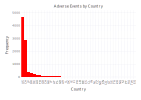

In [24]:
# Adverse events by country
# Bar chart for now.  Consider the JuliaGeo library
d1 = unique(faers17q2_4[:, [:primaryid, :pt, :occr_country]])
d2 = by(d1, :occr_country,
    d -> DataFrame(Frequency = nrow(d)))
sort!(d2, :Frequency, rev = true)

Gadfly.plot(d2, x = :occr_country, y = :Frequency, Geom.bar,
    Guide.xlabel("Country"),
    Guide.ylabel("Frequency"),
    Guide.title("Adverse Events by Country"),
    Scale.y_continuous(format=:plain),
    Theme(default_color = "red"))

In [61]:
#Julia visualization remove after figuring out how to use vegalite
using VegaLite, VegaDatasets

allc |> @vlplot(:bar, 
        x={"occr_country:n", axis={title="Country"}},
        title="Adverse Events by Country and Gender", 
        y={:Frequency, axis={title="Number of AEs"}}, 
        color={"gender:n", scale={range=["#1f77b4","#e377c2"]}},
        height=400,
        width=600)



┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
ERROR: LoadError: NodeJS not properly installed. Please run
Pkg.build("NodeJS")
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] top-level scope at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:7
 [3] include at .\boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at .\loading.jl:1094
 [5] include(::Module, ::String) at .\Base.jl:31
 [6] top-level scope at none:2
 [7] eval at .\boot.jl:330 [inlined]
 [8] eval(::Expr) at .\client.jl:432
 [9] top-level scope at .\none:3
in expression starting at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:6
ERROR: LoadError: Failed to precompile NodeJS [2bd173c7-0d6d-553b-b6af-13a54713934c] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\NodeJS\A9Jiy.ji.
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at .\loading.jl:1253

ErrorException: Failed to precompile VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\VegaLite\lrJqi.ji.

In [44]:
#VegaLite data presentation will use data from all drugs
d1 = unique(faers17q2_4[:, [:primaryid, :sex, :pt, :occr_country, :drugname]])
d2 = by(d1, [:occr_country, :sex, :drugname], 
    d -> DataFrame(Frequency = nrow(d)))
sort!(d2, :Frequency, rev = true)
rename!(d2, :sex => :gender)
allc = first(d2,60)




,occr_country,gender,drugname,Frequency
,String⍰,String⍰,String,Int64
1,US,M,RISPERDAL,987
2,CA,F,XOLAIR,577
3,CA,F,PREDNISONE.,552
4,US,F,AUBAGIO,495
5,CA,F,ACTEMRA,442
6,US,M,PROPECIA,405
7,CA,F,METHOTREXATE.,361
8,US,M,RISPERIDONE.,333
9,CA,M,SANDOSTATIN LAR DEPOT,332


In [43]:
allc |> @vlplot(:bar, 
        

        x={"occr_country:n", axis={title="Country"}},
        title="Adverse Events by Country and Gender - Atacand Only", 
        y={:Frequency, axis={title="Number of AEs"}}, 
        color={"gender:n", scale={range=["#1f77b4","#e377c2"]}},
        height=400,
        width=600)

LoadError: UndefVarError: @vlplot not defined

In [45]:
Pkg.add("PlotlyJS")

 Resolving package versions...
 Installed JSExpr ─────── v0.5.1
 Installed PlotlyBase ─── v0.2.6
 Installed Blink ──────── v0.12.0
 Installed PlotlyJS ───── v0.12.90
 Installed Mux ────────── v0.7.0
 Installed LaTeXStrings ─ v1.0.3
 Installed Mustache ───── v0.5.13
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
  [f0f68f2c] + PlotlyJS v0.12.90
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
  [ad839575] + Blink v0.12.0
  [97c1335a] + JSExpr v0.5.1
  [b964fa9f] + LaTeXStrings v1.0.3
  [ffc61752] + Mustache v0.5.13
  [a975b10e] + Mux v0.7.0
  [a03496cd] + PlotlyBase v0.2.6
  [f0f68f2c] + PlotlyJS v0.12.90
  Building Blink ───→ `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\Blink\AO8uN\deps\build.log`
  Building PlotlyJS → `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\PlotlyJS\jUoQf\deps\build.log`


In [46]:
using PlotlyJS

┌ Info: Precompiling PlotlyJS [f0f68f2c-4968-5e81-91da-67840de0976a]
└ @ Base loading.jl:1242


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-6253159920644814219\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-2259487779057769105\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-6253159920644814219\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Int64) at dataframes.jl:98
└ @ Gadfly C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\Gadfly\1wgcD\src\dataframes.jl:98


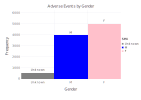

In [47]:
# Adverse events by gender
d2 = unique(faers17q2_4[:, [:primaryid, :pt, :sex]])
d2 = by(d2, :sex,
    d -> DataFrame(Frequency = nrow(d)))
d2[1, :sex] = "Unknown"

palette = ["grey", "blue", "pink"]
# labels = string(d2[:, :Frequency])
# labels

Gadfly.plot(d2, x = :sex, label = 1, y = :Frequency, color = :sex, Geom.bar, 
    Geom.label(position = :above),
    Guide.xlabel("Gender"),
    Guide.ylabel("Frequency"),
    Guide.title("Adverse Events by Gender"),
    Scale.y_continuous(format=:plain),
    Scale.color_discrete_manual(palette...)
    #Guide.annotation(compose(context(), text(:sex, :Frequency, labels)))
    )

In [48]:
describe(d2)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Union…,Type
1,sex,,F,,Unknown,3,0,"Union{Missing, String}"
2,Frequency,3165.67,552,3933.0,5012,,,Int64


In [1]:
# Adverse events by age group
d3 = unique(faers17q2_4[:, [:primaryid, :pt, :age_grp]])
d3 = by(d3, :age_grp,
    d -> DataFrame(Frequency = nrow(d)))
d3[1, :age_grp] = "Unknown"

Gadfly.plot(d3, x = :age_grp, y = :Frequency, color = :age_grp, Geom.bar,
    Guide.xlabel("Age Group"),
    Guide.ylabel("Frequency"),
    Guide.title("Adverse Events by Age Group"),
    Scale.y_continuous(format=:plain),
    Guide.colorkey("Legend=Legend")
    )

UndefVarError: UndefVarError: faers17q2_4 not defined

┌ Warning: `ColorKey(title)` is deprecated, use `ColorKey(title=title)` instead.
│   caller = top-level scope at In[50]:5
└ @ Core In[50]:5


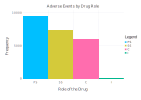

In [50]:
# Adverse events by role of the drug
d4 = unique(faers17q2_4[:, [:primaryid, :pt, :role_cod]])
d4 = by(d4, :role_cod,
    d -> DataFrame(Frequency = nrow(d)))

Gadfly.plot(d4, x = :role_cod, y = :Frequency, color = :role_cod, Geom.bar,
    Guide.xlabel("Role of the Drug"),
    Guide.ylabel("Frequency"),
    Guide.title("Adverse Events by Drug Role"),
    Scale.y_continuous(format=:plain),
    Guide.colorkey("Legend")
    )

In [51]:
d5 = unique(faers17q2_4[:, [:primaryid, :pt]])
d5 = by(d5, :pt,
    d -> DataFrame(Frequency = nrow(d)))
names!(d5, [:Adverse_Event, :AEs_in_2017_Q2])
#rename!(d5, :pt => :Adverse_Event)
sort!(d5, :AEs_in_2017_Q2, rev = true)

,Adverse_Event,AEs_in_2017_Q2
,String⍰,Int64
1,Gynaecomastia,232
2,Abnormal weight gain,172
3,Hyperprolactinaemia,153
4,Fatigue,134
5,Galactorrhoea,130
6,Malaise,96
7,Pain,96
8,Off label use,96
9,Drug ineffective,95


In [52]:
#VegaLite data presentation
head(d5,10)

┌ Warning: `head(df::AbstractDataFrame, n::Integer)` is deprecated, use `first(df, n)` instead.
│   caller = top-level scope at In[52]:1
└ @ Core In[52]:1


,Adverse_Event,AEs_in_2017_Q2
,String⍰,Int64
1,Gynaecomastia,232
2,Abnormal weight gain,172
3,Hyperprolactinaemia,153
4,Fatigue,134
5,Galactorrhoea,130
6,Malaise,96
7,Pain,96
8,Off label use,96
9,Drug ineffective,95


In [53]:
#Julia visualization remove after figuring out how to use vegalite
using VegaLite, VegaDatasets

data = dataset("cars")

data |> @vlplot(:point, 
        x= "Cylinders:o",
        title="Number of Cylinders", 
        y=:Miles_per_Gallon, 
        color="Origin:n",
        height=400,
        width=300)

#data |> @vlplot(:point) |> display

#using VegaLite

#d5 |> @vlplot(:point, x=:AEs_in_2017_Q2, y=:Adverse_Event)


┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
ERROR: LoadError: NodeJS not properly installed. Please run
Pkg.build("NodeJS")
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] top-level scope at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:7
 [3] include at .\boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at .\loading.jl:1094
 [5] include(::Module, ::String) at .\Base.jl:31
 [6] top-level scope at none:2
 [7] eval at .\boot.jl:330 [inlined]
 [8] eval(::Expr) at .\client.jl:432
 [9] top-level scope at .\none:3
in expression starting at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:6
ERROR: LoadError: Failed to precompile NodeJS [2bd173c7-0d6d-553b-b6af-13a54713934c] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\NodeJS\A9Jiy.ji.
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at .\loading.jl:1253

ErrorException: Failed to precompile VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\VegaLite\lrJqi.ji.

In [54]:
Pkg.add("Query")

 Resolving package versions...
 Installed Query ────────── v0.12.2
 Installed QueryOperators ─ v0.9.1
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Project.toml`
  [1a8c2f83] + Query v0.12.2
  Updating `C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\environments\v1.2\Manifest.toml`
  [1a8c2f83] + Query v0.12.2
  [2aef5ad7] + QueryOperators v0.9.1


In [55]:
using VegaLite, VegaDatasets

dataset("gapminder-health-income") |>
@vlplot(
    :circle,
    width=500,height=300,
    selection={
        view={typ=:interval, bind=:scales}
    },
    y={:health, scale={zero=false}},
    x={:income, scale={typ=:log}},
    size=:population,
    color={value="#000"}
)

┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
ERROR: LoadError: NodeJS not properly installed. Please run
Pkg.build("NodeJS")
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] top-level scope at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:7
 [3] include at .\boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at .\loading.jl:1094
 [5] include(::Module, ::String) at .\Base.jl:31
 [6] top-level scope at none:2
 [7] eval at .\boot.jl:330 [inlined]
 [8] eval(::Expr) at .\client.jl:432
 [9] top-level scope at .\none:3
in expression starting at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:6
ERROR: LoadError: Failed to precompile NodeJS [2bd173c7-0d6d-553b-b6af-13a54713934c] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\NodeJS\A9Jiy.ji.
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at .\loading.jl:1253

ErrorException: Failed to precompile VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\VegaLite\lrJqi.ji.

In [56]:
using VegaLite, VegaDatasets

us10m = dataset("us-10m").path
unemployment = dataset("unemployment.tsv").path

@vlplot(
    :geoshape,
    width=500, height=300,
    data={
        url=us10m,
        format={
            typ=:topojson,
            feature=:counties
        }
    },
    transform=[{
        lookup=:id,
        from={
            data=unemployment,
            key=:id,
            fields=["rate"]
        }
    }],
    projection={
        typ=:albersUsa
    },
    color="rate:q"
)

┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
ERROR: LoadError: NodeJS not properly installed. Please run
Pkg.build("NodeJS")
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] top-level scope at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:7
 [3] include at .\boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at .\loading.jl:1094
 [5] include(::Module, ::String) at .\Base.jl:31
 [6] top-level scope at none:2
 [7] eval at .\boot.jl:330 [inlined]
 [8] eval(::Expr) at .\client.jl:432
 [9] top-level scope at .\none:3
in expression starting at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:6
ERROR: LoadError: Failed to precompile NodeJS [2bd173c7-0d6d-553b-b6af-13a54713934c] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\NodeJS\A9Jiy.ji.
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at .\loading.jl:1253

ErrorException: Failed to precompile VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\VegaLite\lrJqi.ji.

In [57]:
using VegaLite, DataFrames

x = [j for i in -5:4, j in -5:4]
y = [i for i in -5:4, j in -5:4]
z = x.^2 .+ y.^2
data = DataFrame(x=vec(x'),y=vec(y'),z=vec(z'))

data |> @vlplot(:rect, x="x:o", y="y:o", color=:z)

┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1242
ERROR: LoadError: NodeJS not properly installed. Please run
Pkg.build("NodeJS")
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] top-level scope at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:7
 [3] include at .\boot.jl:328 [inlined]
 [4] include_relative(::Module, ::String) at .\loading.jl:1094
 [5] include(::Module, ::String) at .\Base.jl:31
 [6] top-level scope at none:2
 [7] eval at .\boot.jl:330 [inlined]
 [8] eval(::Expr) at .\client.jl:432
 [9] top-level scope at .\none:3
in expression starting at C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\packages\NodeJS\rx0mH\src\NodeJS.jl:6
ERROR: LoadError: Failed to precompile NodeJS [2bd173c7-0d6d-553b-b6af-13a54713934c] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\NodeJS\A9Jiy.ji.
Stacktrace:
 [1] error(::String) at .\error.jl:33
 [2] compilecache(::Base.PkgId, ::String) at .\loading.jl:1253

ErrorException: Failed to precompile VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a] to C:\Users\musgr\.juliapro\JuliaPro_v1.2.0-1\compiled\v1.2\VegaLite\lrJqi.ji.

## Julia Opportunities

Please note that all limitations are based on the collective experience of the project team.  There may be work-arounds to these issues that we have not yet had time to discover.

* Speed
    * Julia's performance on the ETL is slower than SQL would be expected to be.
        * Severity: Low
        * Possible work-arounds: Write a reproducible Julia script to create SQL pointers.  These could be faster than the join() function.

* Visualization
    * Currently no way to build interactive dashboards in a way like RShiny
        * Severity: Moderate
        * Possible work-arounds: Plotly API

* Reading CSVs
    * CSV.read() is very cumbersome becuase of manual specification of variable names
        * Severity: Low